# [Micrograd](https://github.com/karpathy/micrograd)
A small autograd engine that implements backpropagation (reverse-mode autodiff) over a dynamically built DAG and a small neural network library on top of it, similar to PyTorch's API.
- Works on scalar values, in practice tensors are used (array of scalars)

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

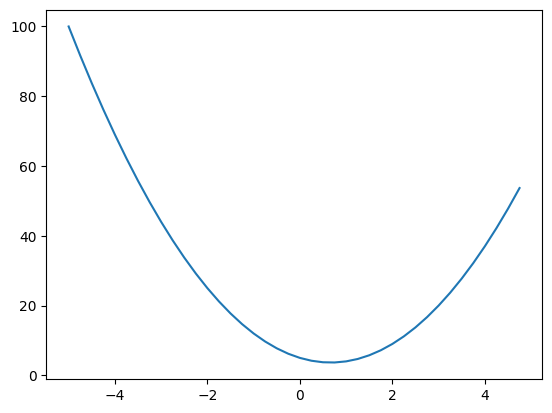

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [14]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [15]:
# More complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [16]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

#
d1 = a*b + c
a += h
d2 = a*b + c

print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'slope: {(d2-d1)/h}')

d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [36]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

In [58]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [59]:
d._op

'+'

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})       # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

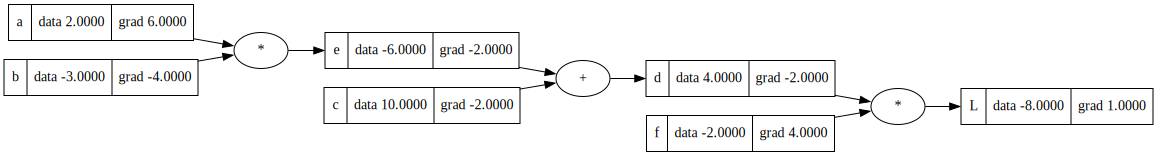

In [76]:
draw_dot(L)

dd / dc ?  1.0

d = c + e


L = d * f

dL/dd =? f

(f(x+h)-f(x))/h
((d+h)*f - d*f) / h
(d*f + h*f - d*f) / h
(h*f)/h
f

In [74]:
a.grad = b.data * e.grad
b.grad = a.data * e.grad
c.grad = d.grad
e.grad = c.grad
f.grad = d.data * L.grad
d.grad = f.data * L.grad
L.grad = 1.0

In [64]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)
lol()

6.000000000021544


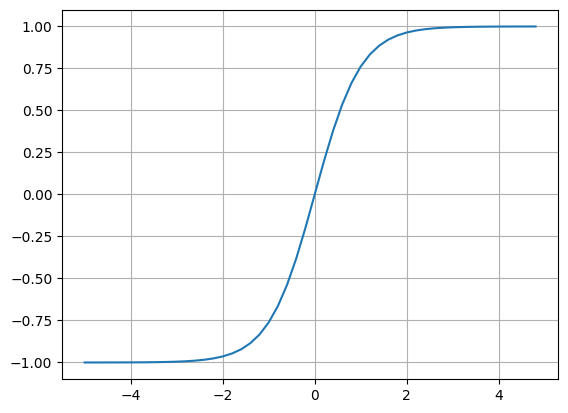

In [77]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [4]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

# x1*w1 + x2*w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = 'o'

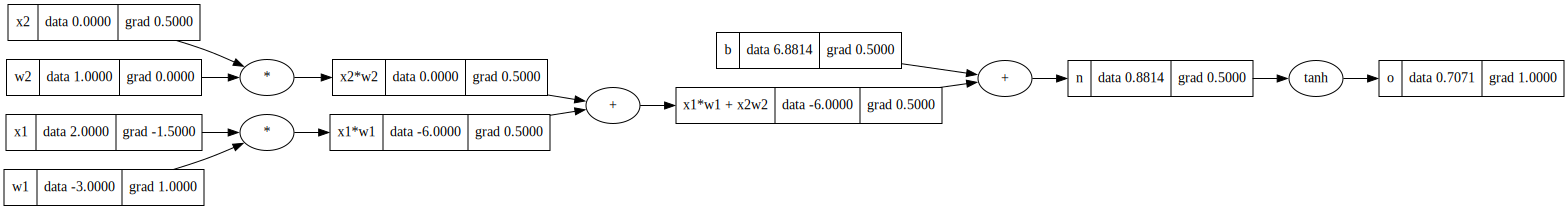

In [7]:
draw_dot(o)

In [6]:
o.backward()

In [135]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [125]:
o.grad = 1.0

In [126]:
o._backward()

In [129]:
n._backward()

In [130]:
b._backward()

In [132]:
x1w1x2w2._backward()

In [133]:
x2w2._backward()
x1w1._backward()

In [106]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [104]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [102]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [100]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [98]:
n.grad = 0.5

In [96]:
o.grad = 1.0

In [97]:
1 - o.data**2

0.4999999999999999

In [ ]:
# o = tanh(n)
# do/dn = 1 - o**2

# Make sure to accumulate the gradients - see video for example

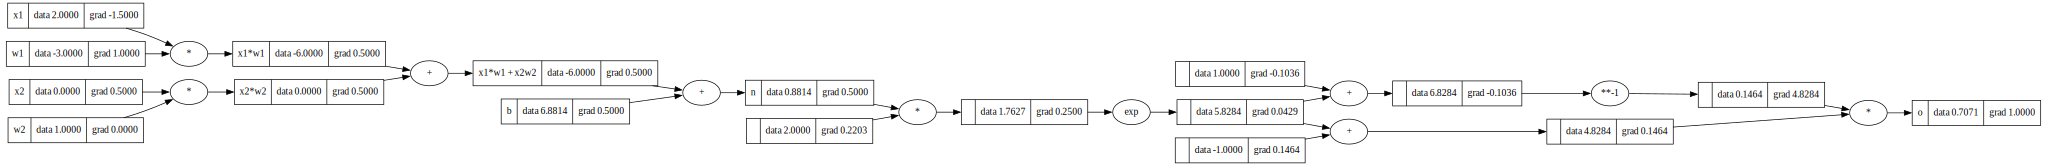

In [160]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

# x1*w1 + x2*w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

In [9]:
import torch

In [11]:
x1 = torch.Tensor([2.0]).double()           ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()           ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()           ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()           ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
import random

In [44]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [45]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.3685452064184553)

In [46]:
n.parameters()

[Value(data=-0.28973719025444167),
 Value(data=-0.9045557376360278),
 Value(data=0.35498166218511007),
 Value(data=-0.3540604077601375),
 Value(data=-0.6401031094677843),
 Value(data=-0.40133013563736175),
 Value(data=-0.1305810235022995),
 Value(data=-0.5329977316475243),
 Value(data=-0.7877605241345484),
 Value(data=0.19652642917048535),
 Value(data=-0.2901532576067316),
 Value(data=0.15169977433588633),
 Value(data=-0.234547573331922),
 Value(data=0.6366653123003652),
 Value(data=-0.07325395816104674),
 Value(data=-0.11463497019426372),
 Value(data=0.9710306079337268),
 Value(data=-0.8576366060926874),
 Value(data=-0.6329344629249758),
 Value(data=0.18646732197652227),
 Value(data=-0.5296837814920972),
 Value(data=0.0020302565515746274),
 Value(data=0.6056872310682284),
 Value(data=-0.33236602848781205),
 Value(data=0.3999160822777539),
 Value(data=-0.8310548103457052),
 Value(data=-0.493949703028735),
 Value(data=0.7820998998062318),
 Value(data=-0.5005612162761404),
 Value(data=0.

In [47]:
len(n.parameters())

41

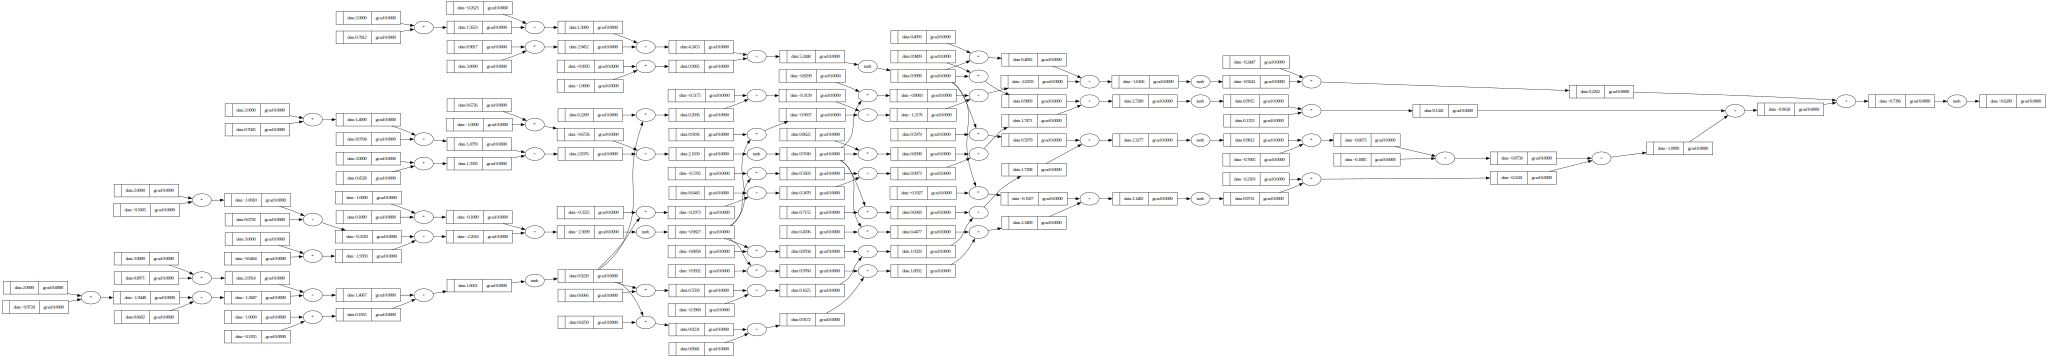

In [27]:
draw_dot(n(x))

In [48]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets



[Value(data=0.3685452064184553),
 Value(data=0.4366737518110558),
 Value(data=0.5681826036819164),
 Value(data=0.6952881948929701)]

In [177]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(x, loss.data)

[2.0, 3.0, -1.0] 0.0017106527583259721
[2.0, 3.0, -1.0] 0.001706304796652227
[2.0, 3.0, -1.0] 0.0017019780357960727
[2.0, 3.0, -1.0] 0.0016976723235939744
[2.0, 3.0, -1.0] 0.001693387509321416
[2.0, 3.0, -1.0] 0.0016891234436759133
[2.0, 3.0, -1.0] 0.0016848799787605
[2.0, 3.0, -1.0] 0.0016806569680672789
[2.0, 3.0, -1.0] 0.0016764542664612528
[2.0, 3.0, -1.0] 0.001672271730164382
[2.0, 3.0, -1.0] 0.0016681092167398844
[2.0, 3.0, -1.0] 0.0016639665850767063
[2.0, 3.0, -1.0] 0.0016598436953742558
[2.0, 3.0, -1.0] 0.0016557404091272743
[2.0, 3.0, -1.0] 0.0016516565891110209
[2.0, 3.0, -1.0] 0.0016475920993665647
[2.0, 3.0, -1.0] 0.0016435468051863129
[2.0, 3.0, -1.0] 0.001639520573099731
[2.0, 3.0, -1.0] 0.0016355132708592984
[2.0, 3.0, -1.0] 0.0016315247674266033


In [153]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.6405080723148124)

In [152]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9999999999291145),
 Value(data=-0.9999998011844632),
 Value(data=-0.9999999079300628),
 Value(data=-0.9997548547919151)]

In [49]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

In [50]:
loss

Value(data=4.616077431805034)

In [146]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0003029254817910968)

In [147]:
loss.backward()

In [148]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [149]:
ypred

[Value(data=0.9916277417733333),
 Value(data=-0.9868507857995794),
 Value(data=-0.9916133266423226),
 Value(data=0.9922742406396408)]

In [52]:
n.layers[0].neurons[0].w[0].grad

-2.8002669977968124

In [55]:
n.layers[0].neurons[0].w[0].data

-0.26173452027647354

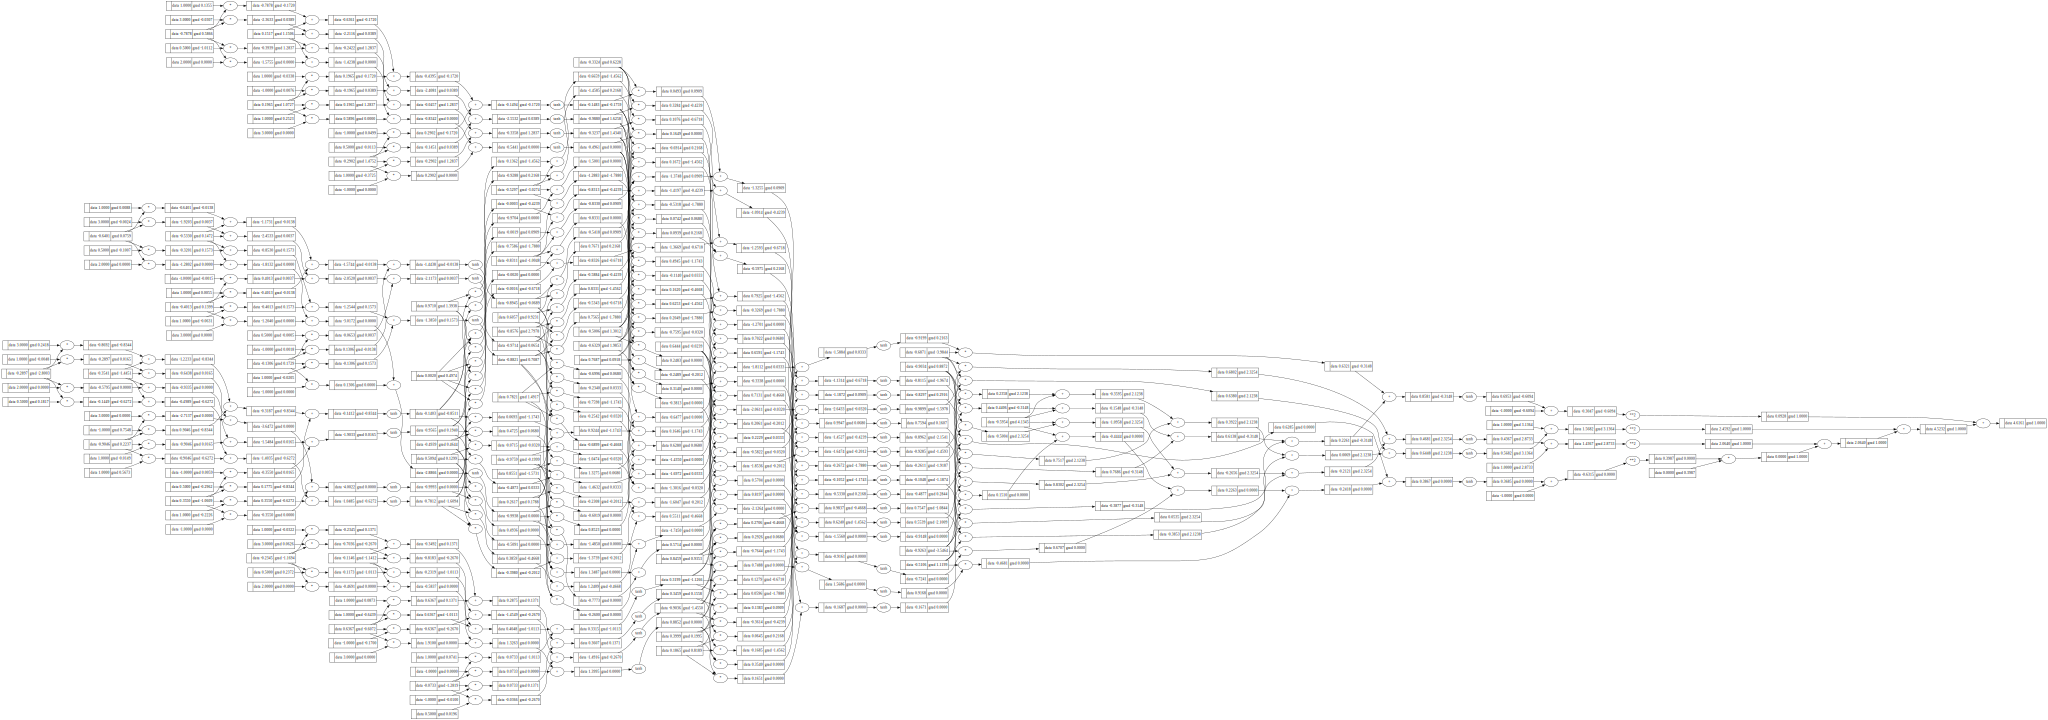

In [53]:
draw_dot(loss)

In [60]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [150]:
n.parameters()

[Value(data=0.4999434331198849),
 Value(data=-0.7792113501217913),
 Value(data=1.3640280520924195),
 Value(data=0.2605402018007965),
 Value(data=-0.3263546400095222),
 Value(data=-0.21612000789921743),
 Value(data=-0.6503863935188597),
 Value(data=-0.32461881363814726),
 Value(data=0.8947287403527079),
 Value(data=1.4429101531668012),
 Value(data=-3.6277293206457895),
 Value(data=1.3533389593542697),
 Value(data=-0.302855682106298),
 Value(data=0.05220509152231456),
 Value(data=1.7452324270619601),
 Value(data=-0.2734649183968751),
 Value(data=2.2898978026543166),
 Value(data=-0.5651280118224957),
 Value(data=-1.9451279790543694),
 Value(data=-0.7340048465741128),
 Value(data=-0.917794129041384),
 Value(data=0.27945363098583),
 Value(data=0.44161124391345974),
 Value(data=-0.850289546129729),
 Value(data=0.10509763453430201),
 Value(data=-0.6721524888274084),
 Value(data=-0.08881314624813771),
 Value(data=0.2292498187444936),
 Value(data=-1.544398816389824),
 Value(data=0.0185104705111